In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


['/content/drive/MyDrive/RBL/INSAT 3D Dataset/25.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/101.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/119.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/106.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/128.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/111.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/112.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/115.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/27.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/102.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/118.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/33(2).jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/31.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/34(!).jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/36(1).jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/32.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/34.jpg', '/content/drive/MyDrive/RBL/INSAT 3D Dataset/30(1).jpg', '/cont

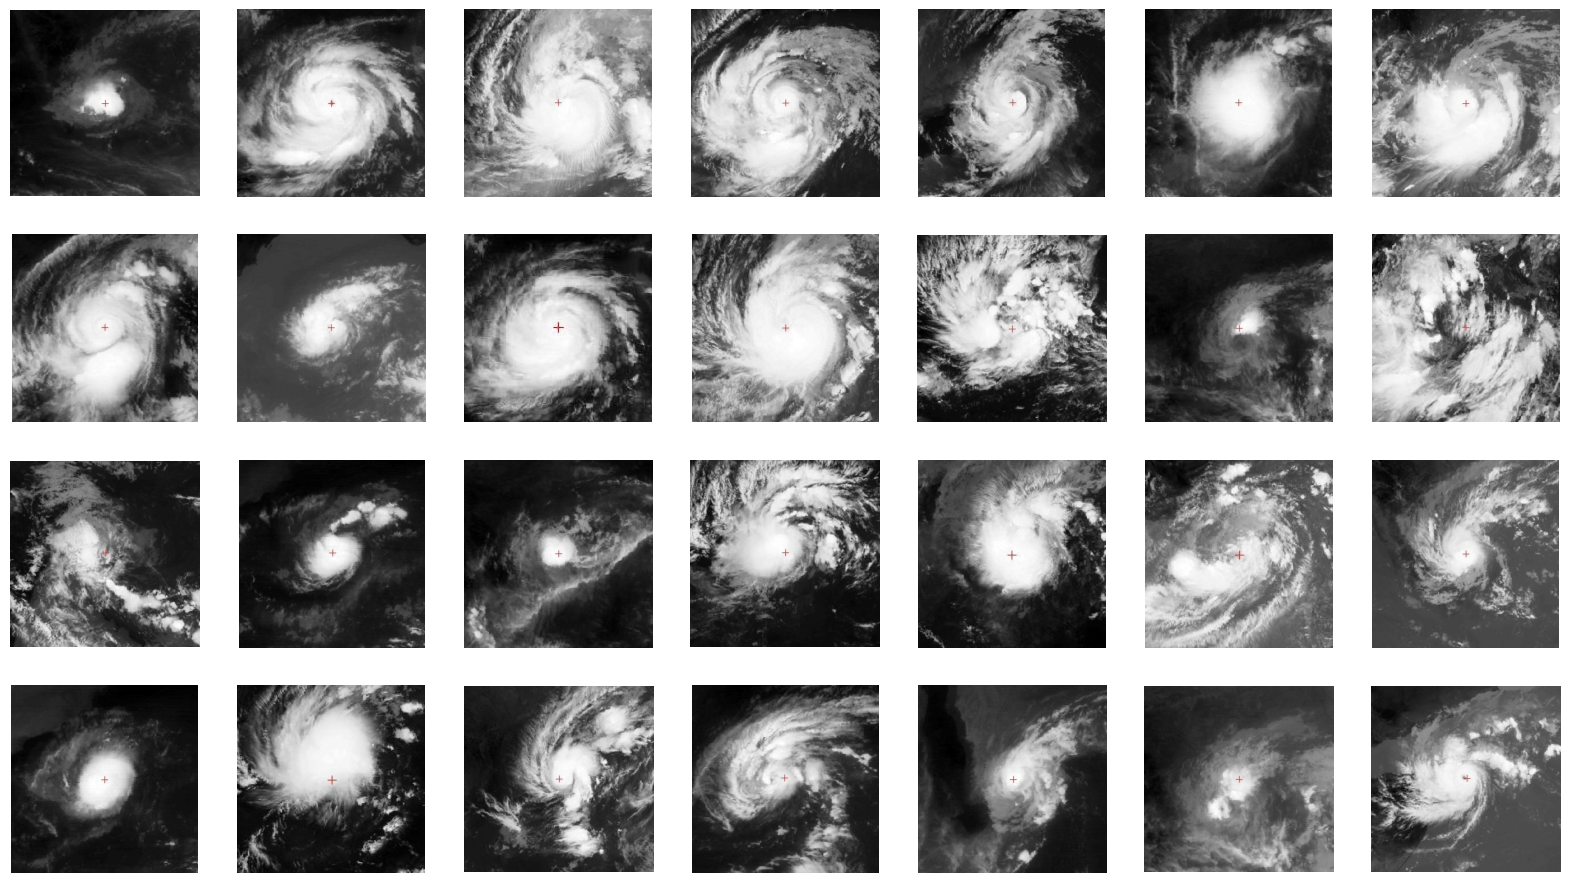

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
paths = glob.glob("/content/drive/MyDrive/RBL/INSAT 3D Dataset/*.jpg")
print(paths)
plt.figure(figsize=(20, 20))
for i in range(28):
    cur_img = mpimg.imread(paths[i])
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(cur_img.astype("uint8"))
    plt.axis("off")

In [ ]:
train_data=train_datagen.flow_from_dataframe(train, directory='/content/drive/MyDrive/INSAT 3D Dataset',x_col='img_name',
                                             y_col='label',subset='training',
                                             target_size=(512,512),batch_size=16,shuffle=True,class_mode='raw')
labels_train = pd.read_csv("/content/drive/MyDrive/RBL/Intensity Values.csv")

In [ ]:
for image_batch,label_batch in train_data:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(16, 512, 512, 3)
(16,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Capsule layer
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, capsule_dim, routings=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_capsule_dim = input_shape[3]
        self.W = self.add_weight(
            shape=(self.input_num_capsules, self.num_capsules * self.capsule_dim, self.input_capsule_dim),
            initializer='glorot_uniform', name='W'
        )
    # Modify the computation of inputs_hat in CapsuleLayer
    def call(self, inputs):
        # Expand dimensions and tile
        inputs_expand = tf.expand_dims(inputs, axis=2)
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1, 1])

        # Reshape W to make dimensions compatible
        W_reshaped = tf.reshape(self.W, [1, self.input_num_capsules, self.input_capsule_dim, self.num_capsules * self.capsule_dim])
        W_tiled = tf.tile(W_reshaped, [tf.shape(inputs)[0], 1, 1, 1])

        # Reshape inputs_tiled_reshaped for compatibility in matmul
        inputs_tiled_reshaped = tf.reshape(inputs_tiled, [tf.shape(inputs_tiled)[0], self.input_num_capsules * self.num_capsules, self.input_capsule_dim])

        # Transpose and reshape inputs_tiled_reshaped for compatibility in matmul
        inputs_tiled_reshaped = tf.transpose(inputs_tiled_reshaped, [0, 2, 1])

        # Compute predictions
        inputs_hat = tf.matmul(W_tiled, tf.expand_dims(inputs_tiled_reshaped, axis=-1))
        inputs_hat = tf.squeeze(inputs_hat, axis=-1)

        # Reshape inputs_hat for compatibility
        inputs_hat = tf.reshape(inputs_hat, [-1, self.input_num_capsules, self.num_capsules, self.capsule_dim])

        # Routing algorithm
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.input_num_capsules, self.num_capsules])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            outputs = tf.reduce_sum(c[:, :, :, None] * inputs_hat, axis=1)
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * outputs[:, None, :, :], axis=-1)

        return self.squash(outputs)

    def squash(self, s):
        norm = tf.norm(s, axis=-1, keepdims=True)
        return norm / (1 + norm ** 2) * s\


def build_capsule_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    # Convolutional layer
    conv1 = layers.Conv2D(256, (9, 9), activation='relu')(inputs)
    # Primary Capsule layer
    primary_capsules = CapsuleLayer(num_capsules=8, capsule_dim=32, routings=3)(conv1)
    # Flatten capsule output
    flattened_capsules = layers.Flatten()(primary_capsules)
    # Dense layers for regression
    dense1 = layers.Dense(128, activation='relu')(flattened_capsules)
    output = layers.Dense(1, activation='linear')(dense1)  # Linear activation for regression
    model = models.Model(inputs=inputs, outputs=output)
    return model

# Sample input shape
input_shape = (512, 512, 3)

# Build the Capsule Neural Network model
model = build_capsule_network(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['rmse'])

# Save the model
save_best = tf.keras.callbacks.ModelCheckpoint("Model1.h5", monitor='loss',save_best_only=True, verbose=1)

# Train the model
model.fit(images_train, labels_train, validation_data=(images_test, labels_test), epochs=50, batch_size=10)

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 29.0513 - root_mean_squared_error: 36.6466
Epoch 1: loss improved from inf to 29.05133, saving model to Model1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 29s 2s/step - loss: 29.0513 - root_mean_squared_error: 36.6466
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 21.3345 - root_mean_squared_error: 26.8988
Epoch 2: loss improved from 29.05133 to 21.33451, saving model to Model1.h5
9/9 [==============================] - 7s 862ms/step - loss: 21.3345 - root_mean_squared_error: 26.8988
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 12.7369 - root_mean_squared_error: 16.1740
Epoch 3: loss improved from 21.33451 to 12.73689, saving model to Model1.h5
9/9 [==============================] - 14s 2s/step - loss: 12.7369 - root_mean_squared_error: 16.1740
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 9.1748 - root_mean_squared_error: 12.4588
Epoch 4: loss improved from 12.73689 to 9.17478, saving model to Model1.h5
9/9 [==============================] - 7s 815ms/step - loss: 9.1748 - root_mean_squared_error: 12.4588
Epoch 5/50
9/9 [====================

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/RBL/Model.h5")

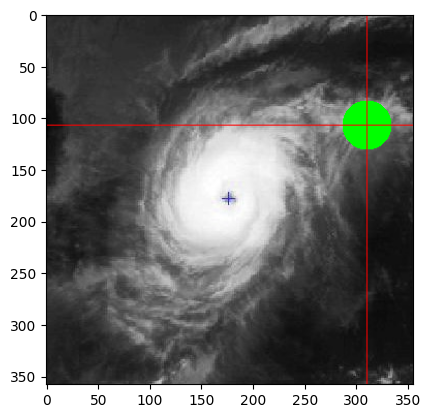

310.0 107.5


In [ ]:
import cv2

# Load the image
image = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/81.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blur, 100, 200)

# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Get the minimum enclosing circle of the largest contour
(x, y), radius = cv2.minEnclosingCircle(largest_contour)

# Draw a circle at the center of the eye
cv2.circle(image, (int(x), int(y)), int(radius), (0, 255, 0), -1)

cv2.line(image, (int(x), 0), (int(x), image.shape[0]), (255, 0, 0), 1)  # Vertical line
cv2.line(image, (0, int(y)), (image.shape[1], int(y)), (255, 0, 0), 1)  # Horizontal line

# Display the image with the highlighted eye
plt.imshow(image)
plt.show()
print(x, y)

267 356
277 354
222 354
271 352
281 345
310 335
217 314
284 303
310 279
302 266
305 266
327 263
319 254
26 233
34 232
23 227
332 188
326 188
351 184
304 289
336 182
47 179
345 177
346 171
348 168
5 105
298 44
335 44
294 39
302 29
329 31
Average temperature around the eye of the cyclone: 19.133414753297508


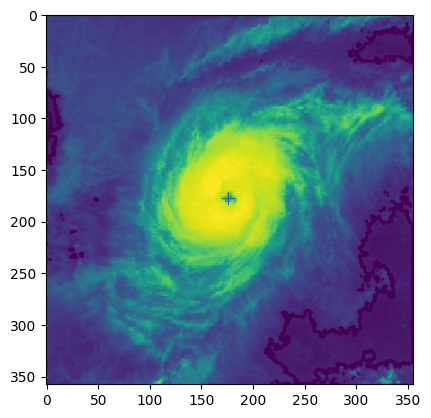

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Load the image
image = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/81.jpg', cv2.IMREAD_GRAYSCALE)


# Define temperature ranges
temperature_ranges = {'blue': (23, 25), 'dark_blue': (20, 23), 'darkest_blue': (15, 20),
                      'yellow': (25, 27), 'red': (27, 29), 'maroon': (29, 31)}

# Threshold the image to extract different temperature ranges
dark_blue_mask = cv2.inRange(image, temperature_ranges['dark_blue'][0], temperature_ranges['dark_blue'][1])
darkest_blue_mask = cv2.inRange(image, temperature_ranges['darkest_blue'][0], temperature_ranges['darkest_blue'][1])

# Combine masks to get the areas of interest
areas_of_interest = cv2.bitwise_or(dark_blue_mask, darkest_blue_mask)

# Find contours to locate the eye of the cyclone
contours, _ = cv2.findContours(areas_of_interest, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables for temperature around the eye
total_temperature_eye = 0
count_eye = 0

# Analyze contour characteristics
for contour in contours:
    # Calculate moments to find centroid
    M = cv2.moments(contour)
    if M['m00'] != 0:
        centroid_x = int(M['m10'] / M['m00'])
        centroid_y = int(M['m01'] / M['m00'])
        print(centroid_x, centroid_y)

        # Calculate average temperature around the centroid within a certain radius
        radius = 25  # You may adjust this radius based on the image resolution
        temperature_sum = 0
        count = 0
        for y in range(centroid_y - radius, centroid_y + radius):
            for x in range(centroid_x - radius, centroid_x + radius):
                if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
                    temperature = image[y, x]
                    if temperature_ranges['dark_blue'][0] <= temperature <= temperature_ranges['dark_blue'][1] or \
                       temperature_ranges['darkest_blue'][0] <= temperature <= temperature_ranges['darkest_blue'][1]:
                        temperature_sum += temperature
                        count += 1
        total_temperature_eye += temperature_sum
        count_eye += count

# Calculate average temperature around the eye
average_temperature_eye = total_temperature_eye / count_eye if count_eye != 0 else 0

# Print the average temperature around the eye
print("Average temperature around the eye of the cyclone:", average_temperature_eye)

# Draw contours on the image
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

# Display the image with the line
plt.imshow(image)
plt.show()

In [ ]:
# Find the centroid of the blue areas
blue_mask = cv2.bitwise_or(dark_blue_mask, darkest_blue_mask)
blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

total_blue_area = 0
centroid_x_sum = 0
centroid_y_sum = 0

for contour in blue_contours:
    # Calculate moments to find centroid
    M = cv2.moments(contour)
    if M['m00'] != 0:
        centroid_x = int(M['m10'] / M['m00'])
        centroid_y = int(M['m01'] / M['m00'])

        # Accumulate centroid coordinates weighted by area
        area = cv2.contourArea(contour)
        centroid_x_sum += centroid_x * area
        centroid_y_sum += centroid_y * area
        total_blue_area += area

# Calculate centroid coordinates
if total_blue_area != 0:
    centroid_x_blue = int(centroid_x_sum / total_blue_area)
    centroid_y_blue = int(centroid_y_sum / total_blue_area)

    # Calculate the center of the image
    image_center_x = image.shape[1] // 2
    image_center_y = image.shape[0] // 2

    # Calculate the distance between the blue areas centroid and the image center
    distance_from_center = np.sqrt((centroid_x_blue - image_center_x) ** 2 + (centroid_y_blue - image_center_y) ** 2)

    # Calculate the maximum possible distance from center (diagonal distance to image corners)
    max_distance_from_center = np.sqrt(image_center_x ** 2 + image_center_y ** 2)

    # Calculate the skewness ratio based on the position of the blue areas centroid
    skewness_ratio = (distance_from_center / max_distance_from_center)

    # Determine skewness
    print(skewness_ratio)
    if skewness_ratio < 0.1:
        print("The blue areas are mostly centered, indicating a balanced and intense cyclone.")
    else:
        print("The blue areas are skewed away from the center, indicating potential weakening of the cyclone.")
else:
    print("No blue areas found.")


0.5520701425750768
The blue areas are skewed away from the center, indicating potential weakening of the cyclone.


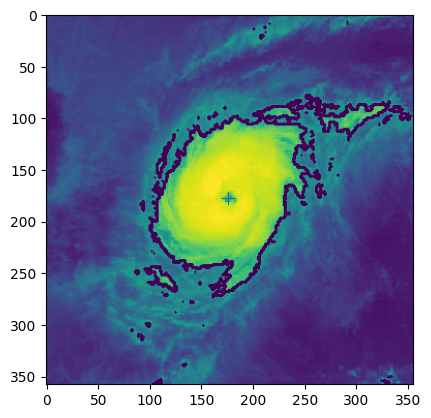

In [ ]:
image = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/81.jpg', cv2.IMREAD_GRAYSCALE)

# Define temperature ranges
temperature_ranges = {'blue': (230, 250), 'dark_blue': (200, 230), 'darkest_blue': (150, 200), 'yellow': (250, 270), 'red': (270, 290), 'maroon': (290, 310)}

# Threshold the image to extract different temperature ranges
dark_blue_mask = cv2.inRange(image, temperature_ranges['dark_blue'][0], temperature_ranges['dark_blue'][1])
darkest_blue_mask = cv2.inRange(image, temperature_ranges['darkest_blue'][0], temperature_ranges['darkest_blue'][1])

# Combine masks to get the areas of interest
areas_of_interest = cv2.bitwise_or(dark_blue_mask, darkest_blue_mask)

# Find contours to locate the eye of the cyclone
contours, _ = cv2.findContours(areas_of_interest, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours around the eye
cv2.drawContours(image, contours, -1, (0, 0, 255), 2)

plt.imshow(image)
plt.show()

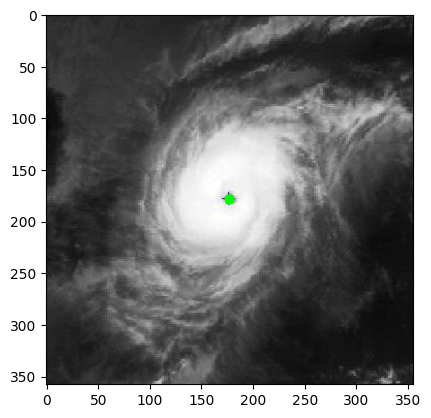

In [ ]:
# Load the image
image = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/81.jpg')

# Get the image dimensions
height, width, channels = image.shape

# Calculate the center point of the image
center_x = int(width / 2)
center_y = int(height / 2)

# Define the radius of the circle
radius = 5

# Draw a circle at the center of the image
cv2.circle(image, (center_x, center_y), radius, (0, 255, 0), -1)

# Display the image with the highlighted center
plt.imshow(image)
plt.show()

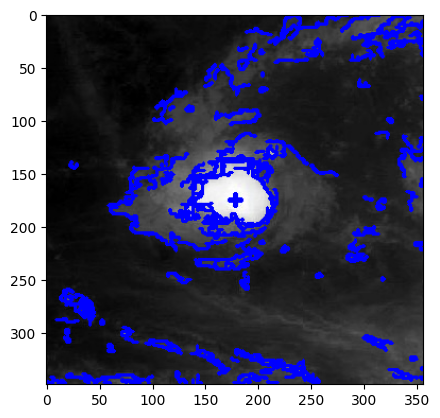

In [ ]:
import cv2

# Load the image
image = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/25.jpg')

# Convert the image to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(image, 50, 100)

# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over all contours and draw them in green
for contour in contours:
    cv2.drawContours(image, [contour], -1, (0, 0, 255), 2)

# Display the image with the highlighted curves
plt.imshow(image)
plt.show()

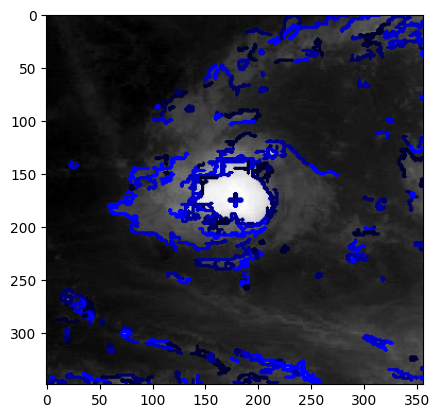

In [ ]:
import cv2

# Load the image
image = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/25.jpg')

# Convert the image to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 100)

# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours by their area in descending order
cs = sorted(contours, key=cv2.contourArea, reverse=True)
# contours.sort(key=cv2.contourArea, reverse=True)

# Define a color palette for different levels of highlighting
# colors = [(0, 255, 0), (0, 200, 0), (0, 150, 0), (0, 100, 0), (0, 50, 0)]
colors = [(0, 0, 255), (0, 0, 200), (0, 0, 150), (0, 0, 100), (0, 0, 50)]

# Iterate over the contours and draw them with different colors based on their level
for i, contour in enumerate(cs):
    color = colors[i % len(colors)]
    cv2.drawContours(image, [contour], -1, color, 2)

# Display the image with the highlighted curves
plt.imshow(image)
plt.show()

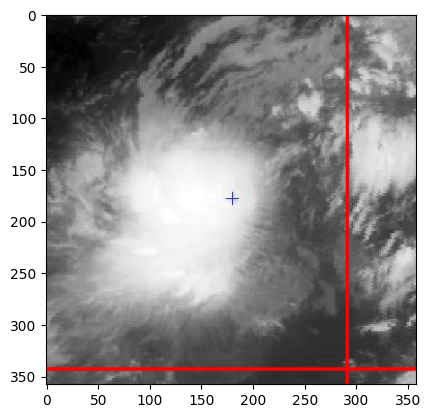

In [ ]:
import cv2
import numpy as np

def find_densest_area_center(image):
  # Approach: Find contours and select the one containing a '+' shape
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  dense_contour = None
  for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)
    if len(approx) == 4 and cv2.isContourConvex(approx):  # Check for '+' shape
      dense_contour = cnt
      break

  if dense_contour is not None:
    M = cv2.moments(dense_contour)
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    return center_x, center_y
  else:
    return None  # No dense area with '+' found

# Load the image
image = cv2.imread("/content/drive/MyDrive/RBL/INSAT 3D Dataset/45.jpg")

# Find the center of the densest area
center_x, center_y = find_densest_area_center(image)

if center_x is not None and center_y is not None:
  # Draw dashed lines
  height, width, channels = image.shape

  # Vertical line
  # line_mask = np.zeros_like(image)
  # line_mask[::dash_length, :] = 255
  # Draw a horizontal red dashed line
  cv2.line(image, (0, center_y), (width, center_y), (255, 0, 0), 2, cv2.LINE_AA)

  # Draw a vertical red dashed line
  # cv2.line(image, (center_x, 0), (center_x, line_length), (0, 0, 255), line_thickness, line_type=cv2.LINE_AA, mask=line_mask)
  cv2.line(image, (center_x, 0), (center_x, height), (255, 0, 0), 2, cv2.LINE_AA)

  plt.imshow(image)
  plt.show()
else:
  print("Fail")

In [ ]:
import cv2
import numpy as np

def find_densest_white_area(image):
  # 1. Thresholding to isolate white areas
  thresh, _ = cv2.threshold(image, 220, 255, cv2.THRESH_BINARY)  # Adjust threshold for your image

  # 2. Morphological operations to refine white regions (optional)
  kernel = np.ones((3, 3), np.uint8)  # Adjust kernel size as needed
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)  # Remove small white noise
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)  # Fill small gaps in white regions

  # 3. Find largest connected component (assuming dense area is a single object)
  # contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours, _ = cv2.findContours(closing.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  largest_area = 0
  largest_contour = None
  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > largest_area:
      largest_area = area
      largest_contour = cnt

  # 4. Calculate center of the largest connected component
  if largest_contour is not None:
    M = cv2.moments(largest_contour)
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    return center_x, center_y
  else:
    return None  # No large white area found

# Load the image (assuming grayscale)
image = cv2.imread("/content/drive/MyDrive/RBL/INSAT 3D Dataset/31.jpg")

# Find the center of the densest white area

center = find_densest_white_area(image)
if center is not None:
  center_x, center_y = center  # Unpack only if a valid center is found
  # Draw dashed lines using center_x and center_y
  if center_x is not None and center_y is not None:
  # Draw dashed lines (code from previous responses)
  # ... (code to draw lines using center coordinates)

  # Display the image with dashed lines
    plt.imshow(image)
    plt.show()
  else:
    print("Fail")
else:
  print("No large dense white area found in the image.")



No large dense white area found in the image.


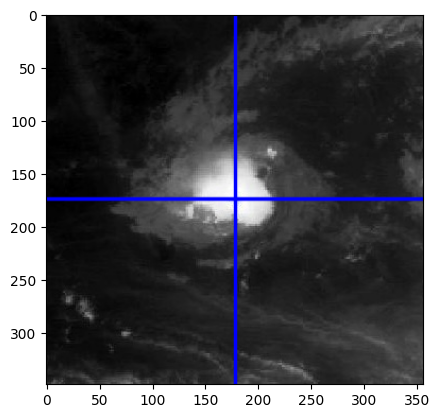

In [ ]:
import cv2

# Load the image
image = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/25.jpg')

# Get the image dimensions
height, width, channels = image.shape

# Calculate the center of the image
center_x = int(width / 2)
center_y = int(height / 2)

# Draw a horizontal red dashed line
cv2.line(image, (0, center_y), (width, center_y), (0, 0, 255), 2, cv2.LINE_AA)

# Draw a vertical red dashed line
cv2.line(image, (center_x, 0), (center_x, height), (0, 0, 255), 2, cv2.LINE_AA)

# Display the image with the lines
plt.imshow(image)
plt.show()

1/1 [==============================] - 3s 3s/step
['block1_conv1', 'block1_conv1_bn', 'block1_conv1_act', 'block1_conv2', 'block1_conv2_bn', 'block1_conv2_act', 'block2_sepconv1', 'block2_sepconv1_bn', 'block2_sepconv2_act', 'block2_sepconv2', 'block2_sepconv2_bn', 'conv2d', 'block2_pool', 'batch_normalization', 'add', 'block3_sepconv1_act', 'block3_sepconv1', 'block3_sepconv1_bn', 'block3_sepconv2_act', 'block3_sepconv2', 'block3_sepconv2_bn', 'conv2d_1', 'block3_pool', 'batch_normalization_1', 'add_1', 'block4_sepconv1_act', 'block4_sepconv1', 'block4_sepconv1_bn', 'block4_sepconv2_act', 'block4_sepconv2', 'block4_sepconv2_bn', 'conv2d_2', 'block4_pool', 'batch_normalization_2', 'add_2', 'block5_sepconv1_act', 'block5_sepconv1', 'block5_sepconv1_bn', 'block5_sepconv2_act', 'block5_sepconv2', 'block5_sepconv2_bn', 'block5_sepconv3_act', 'block5_sepconv3', 'block5_sepconv3_bn', 'add_3', 'block6_sepconv1_act', 'block6_sepconv1', 'block6_sepconv1_bn', 'block6_sepconv2_act', 'block6_sepco

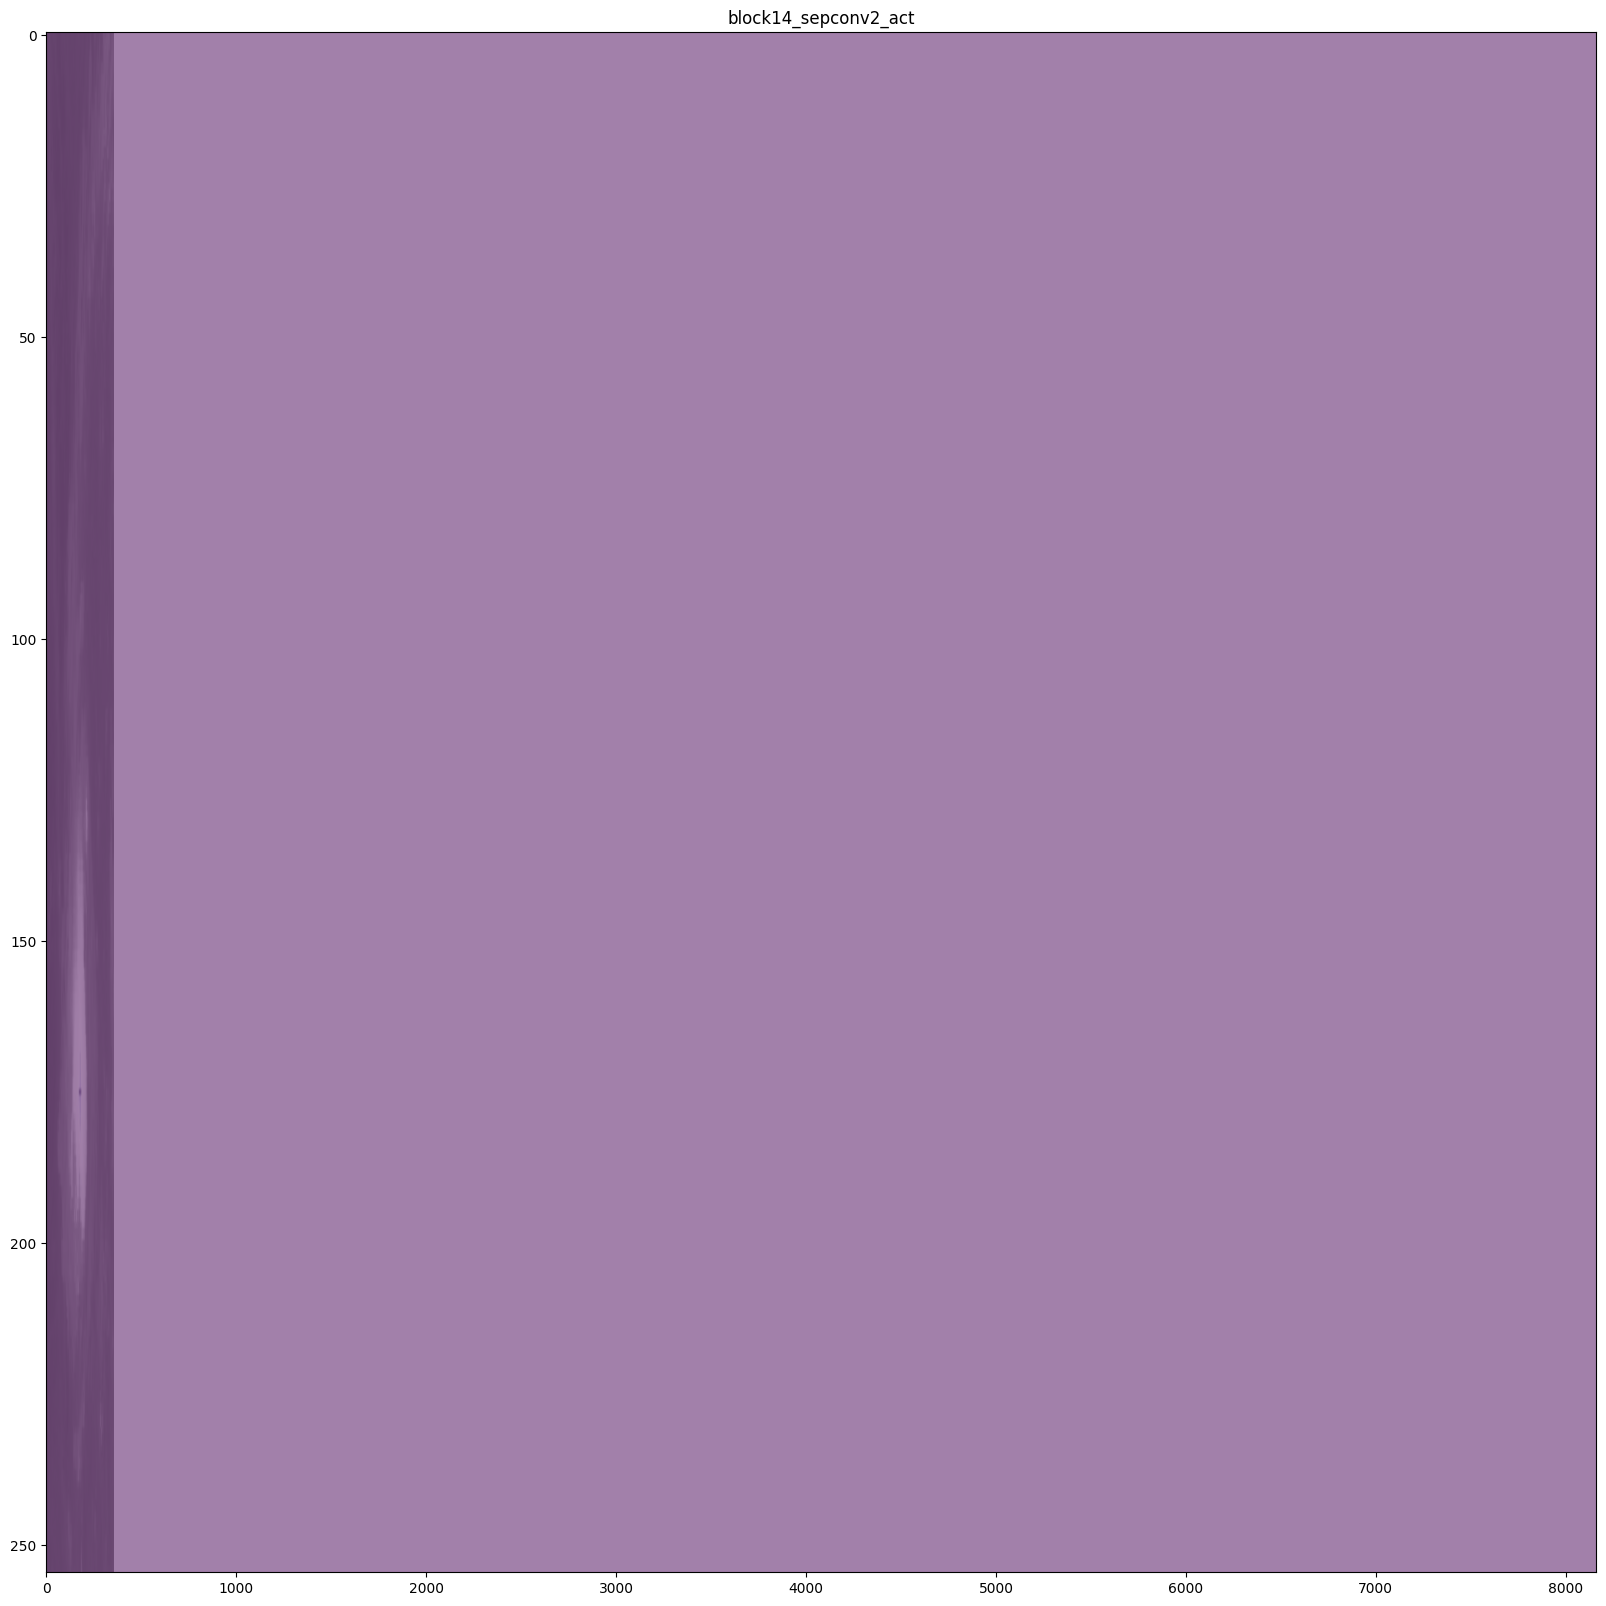

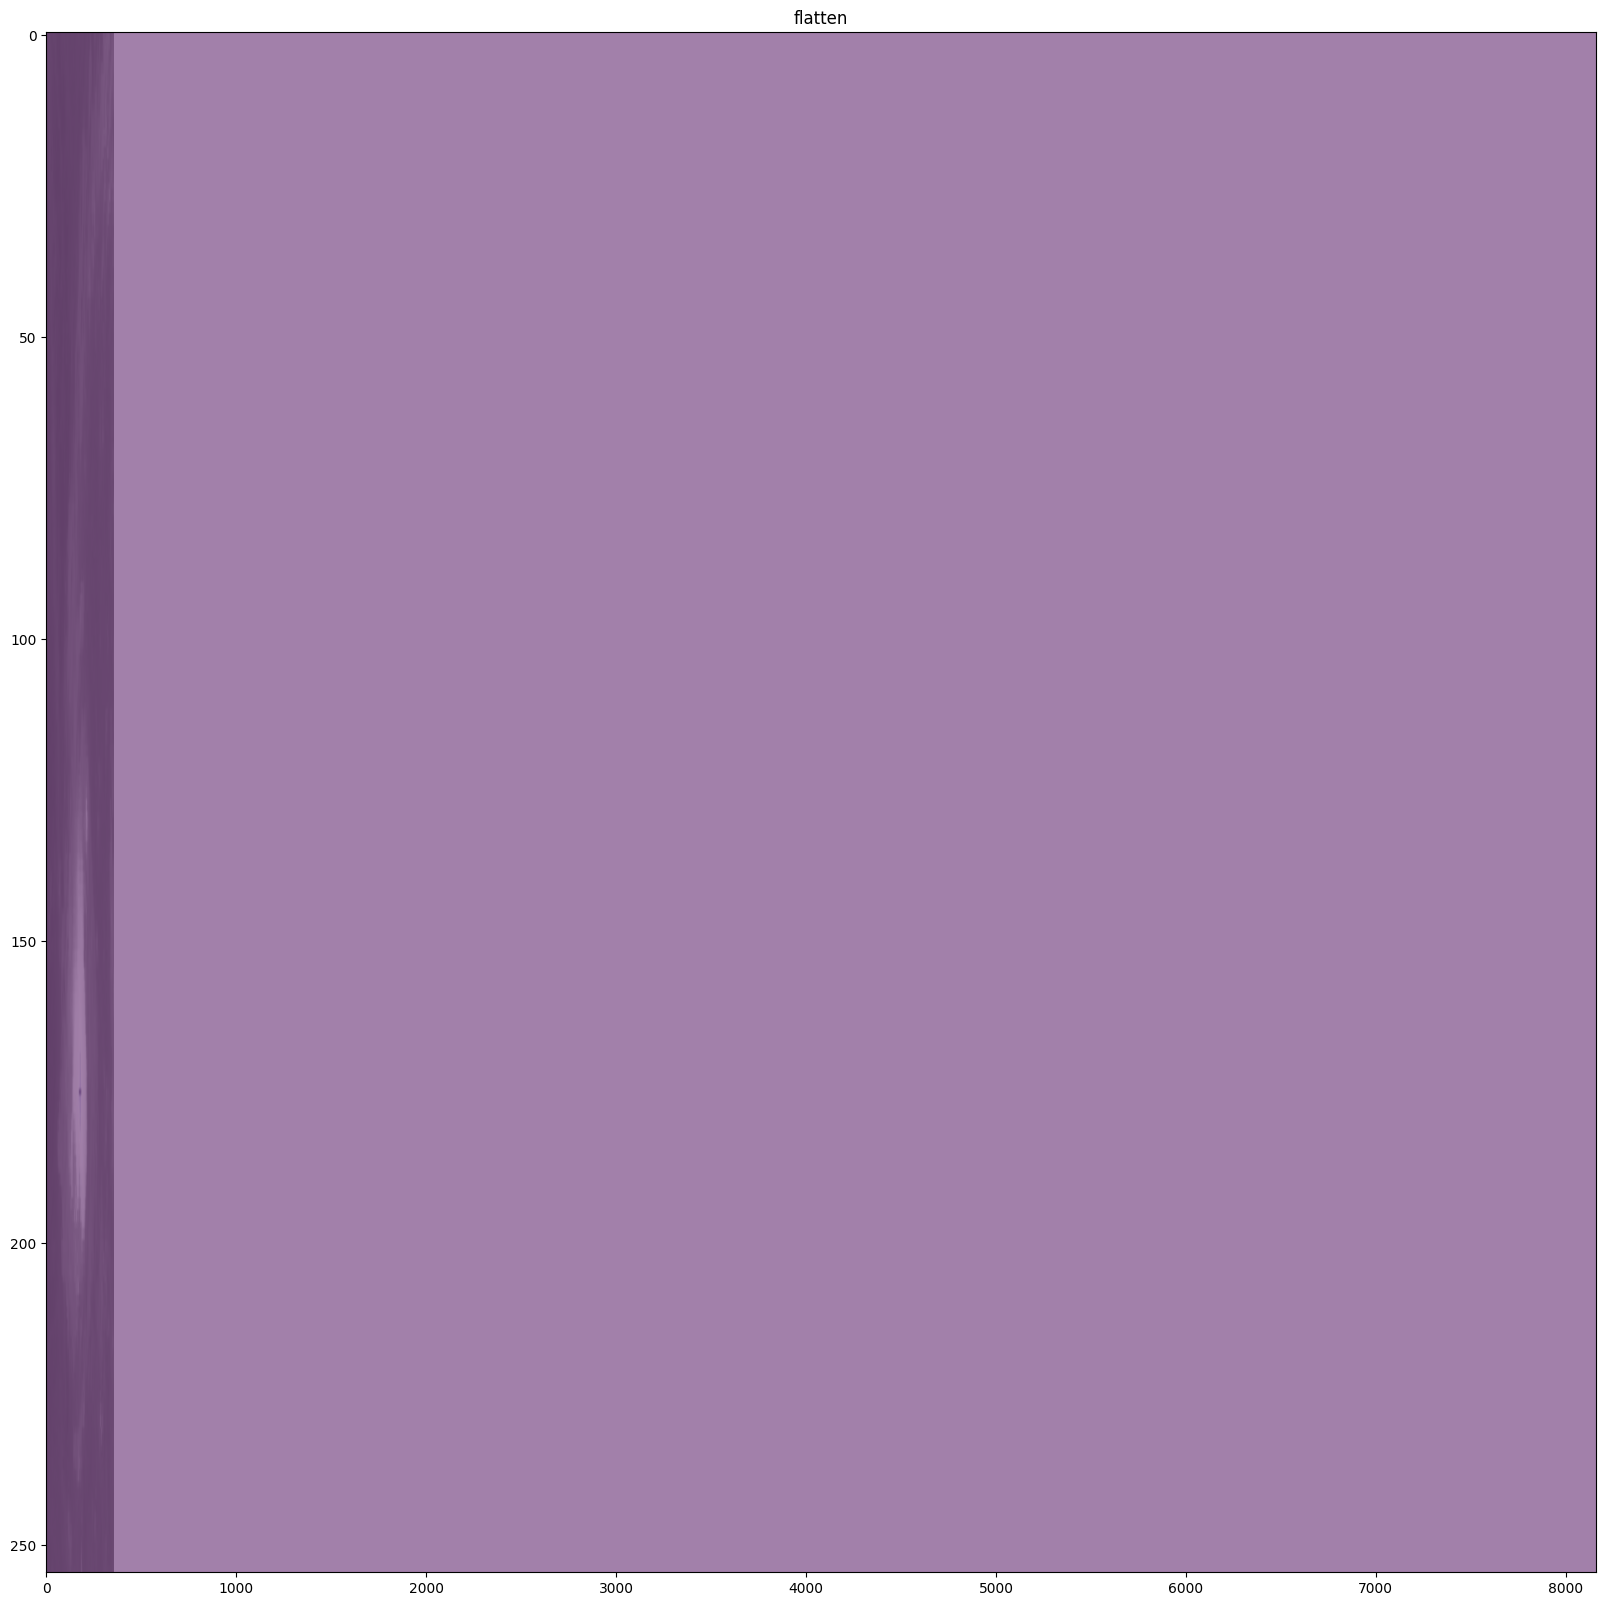

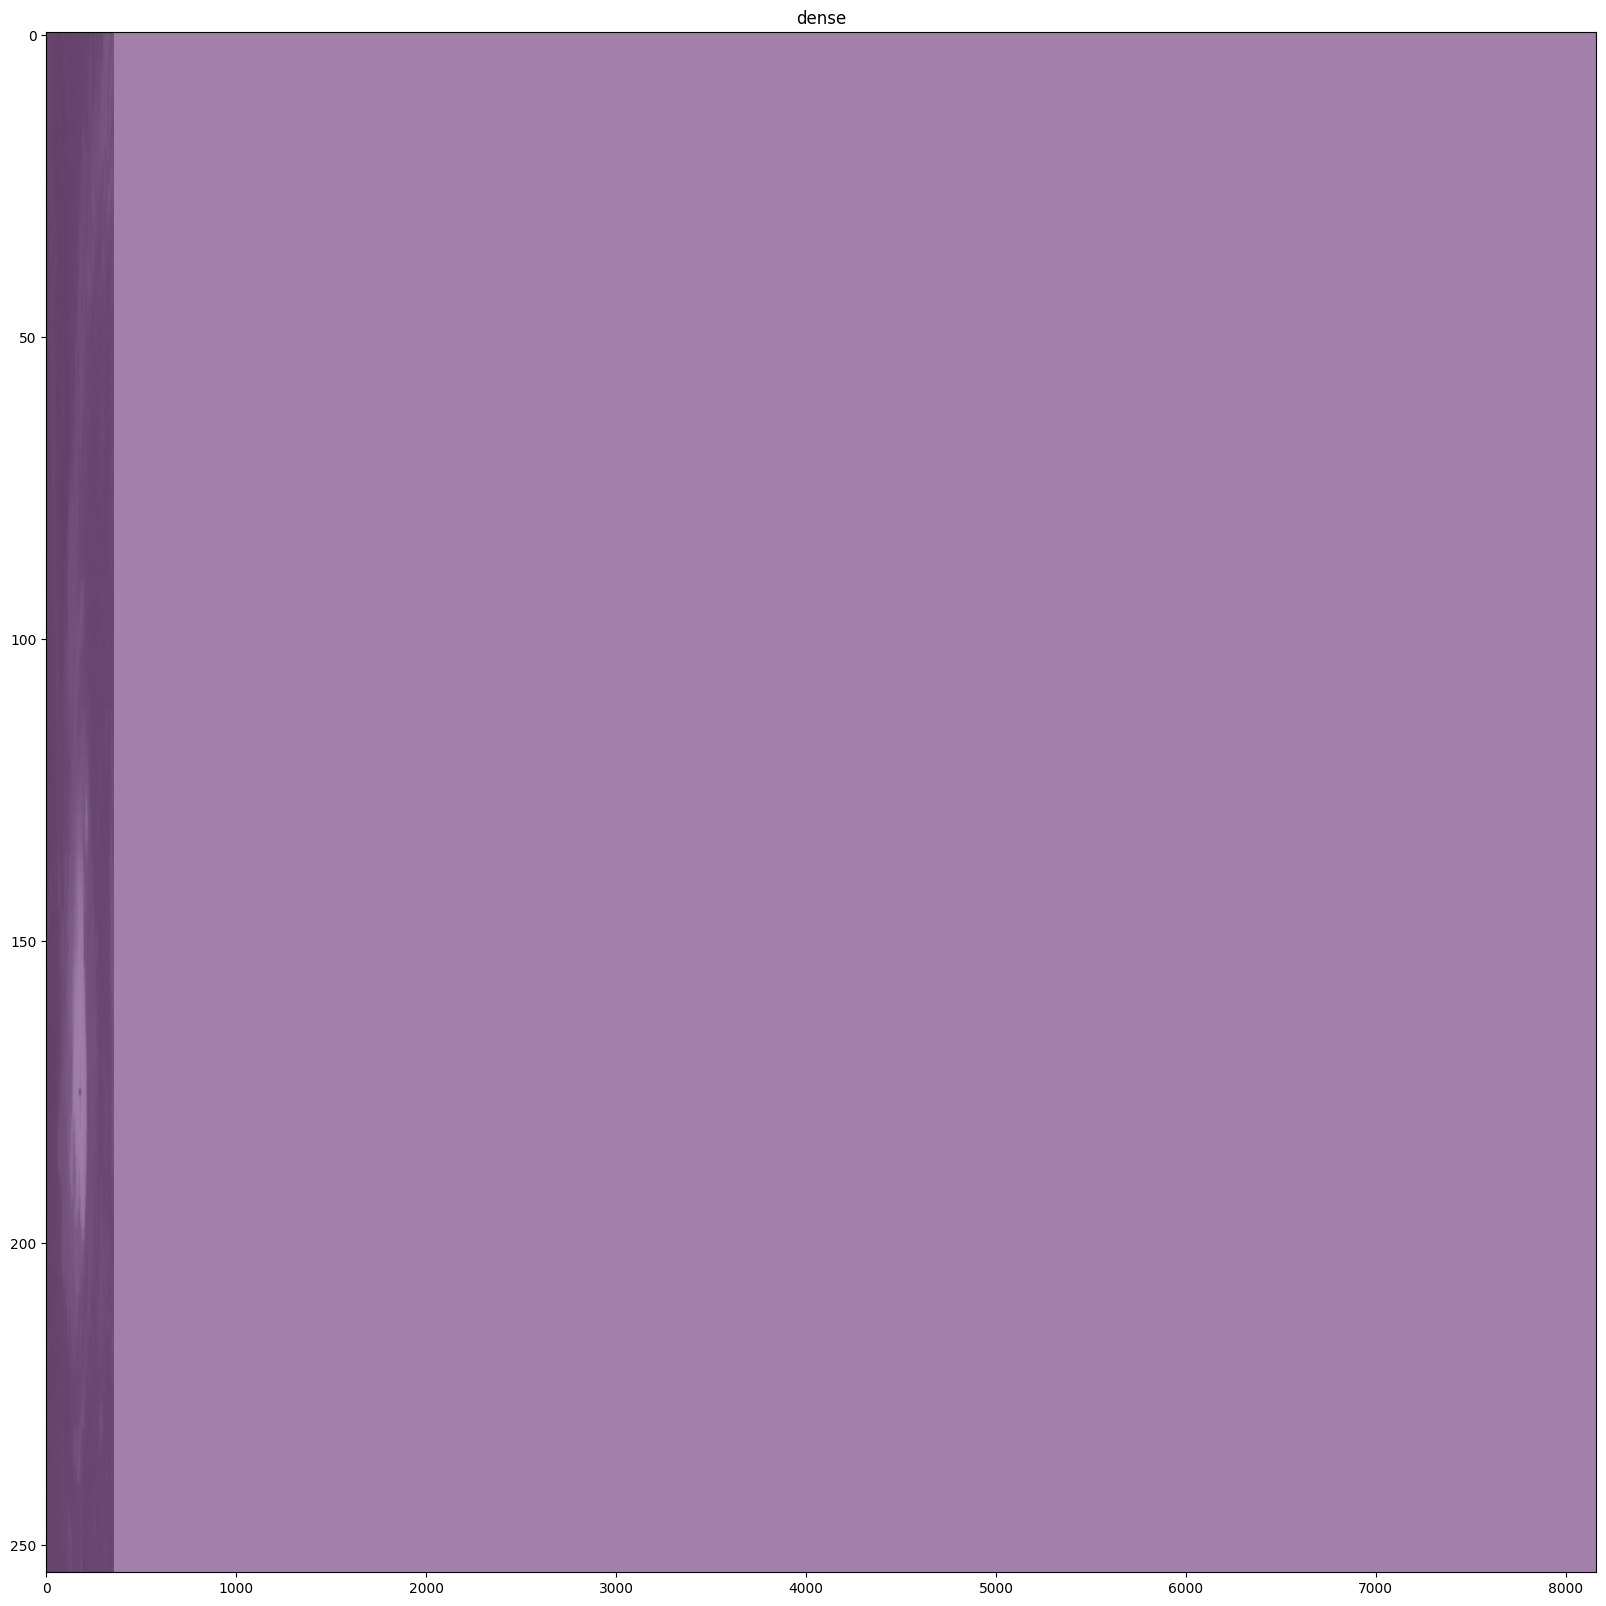

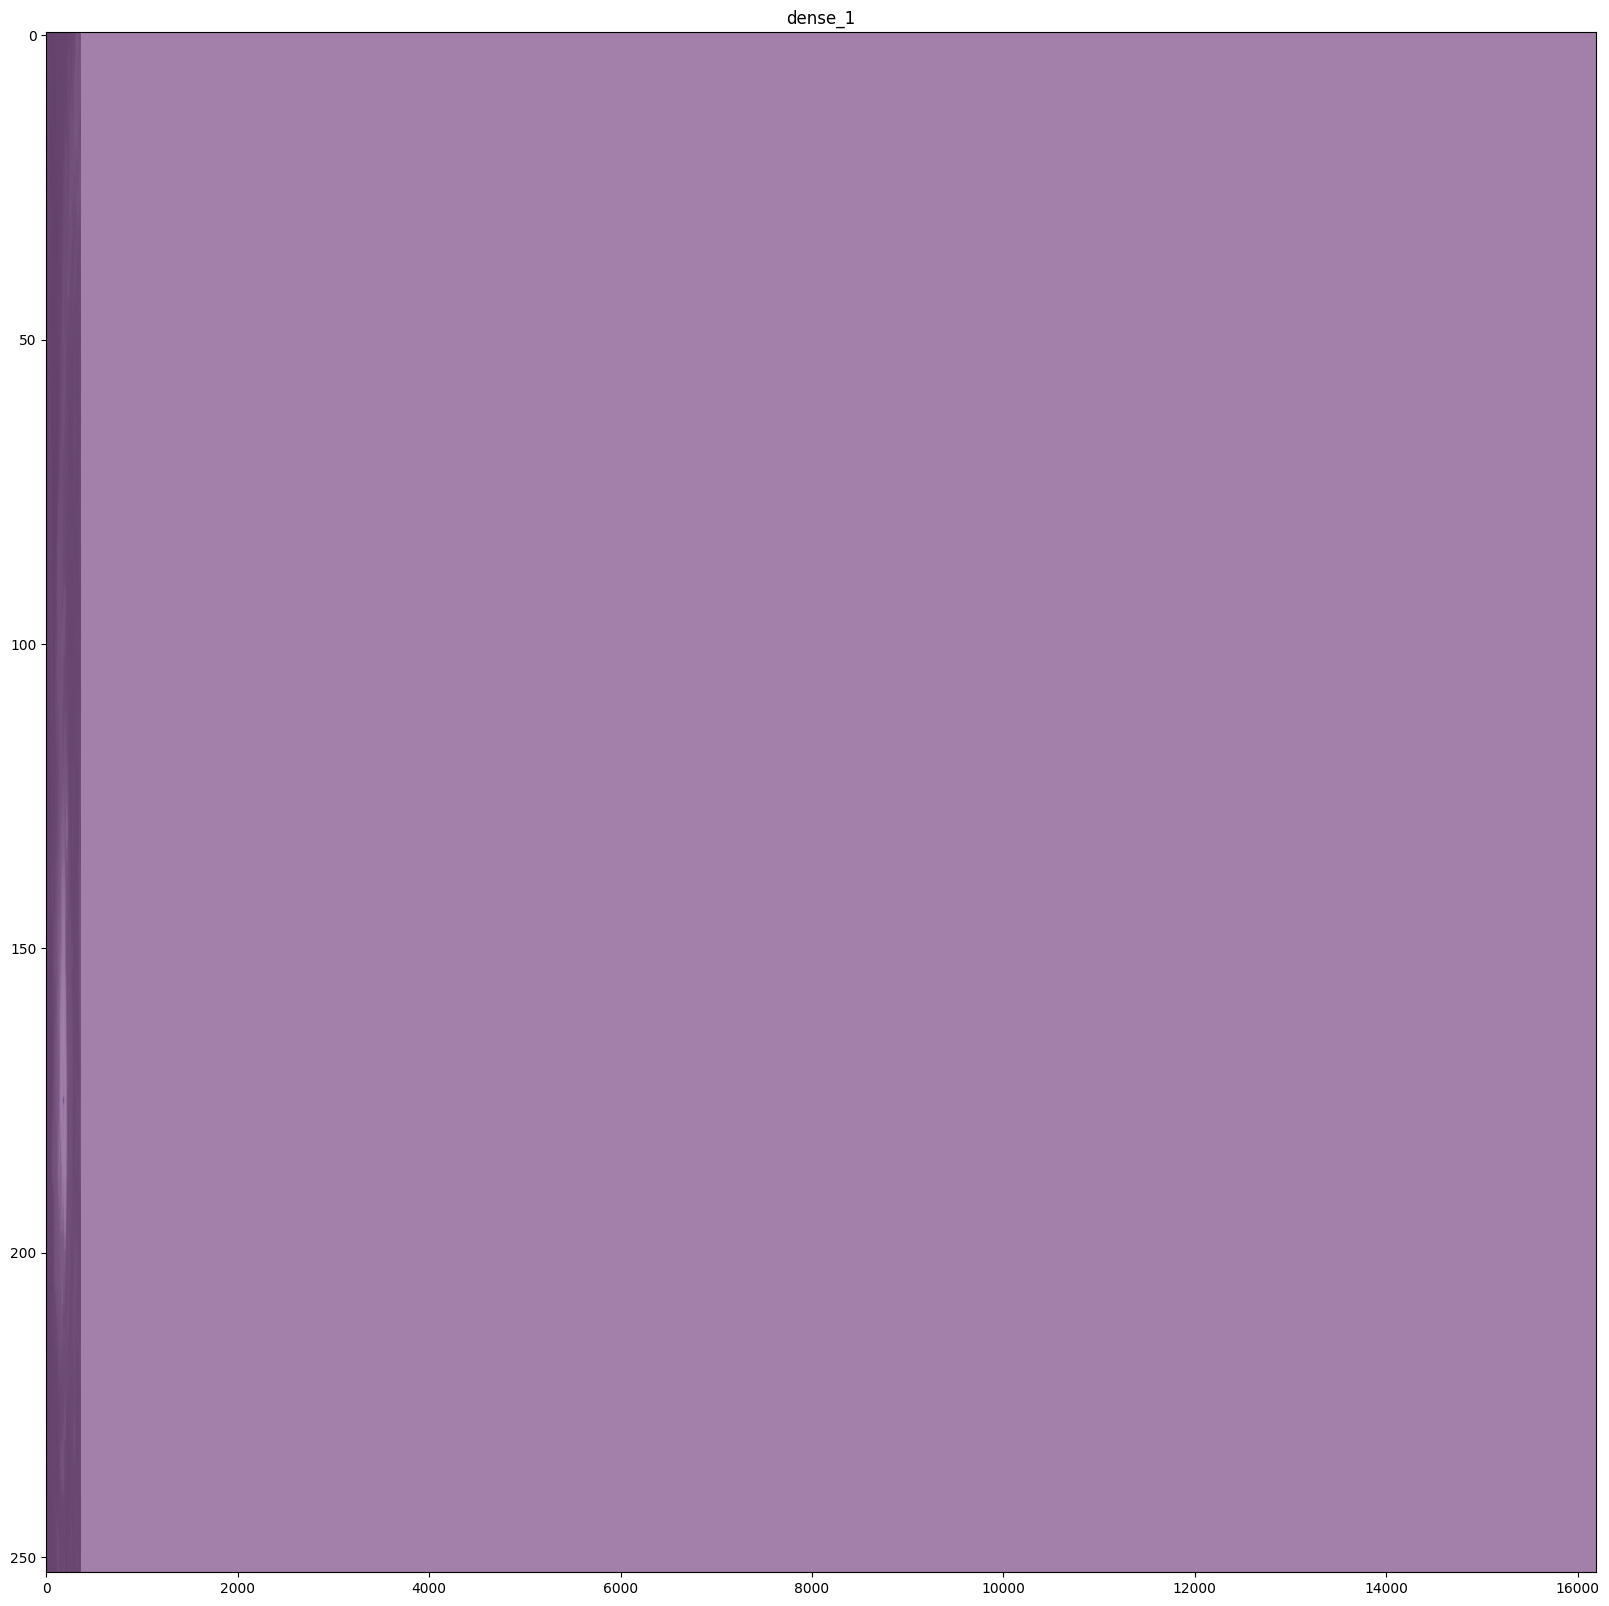

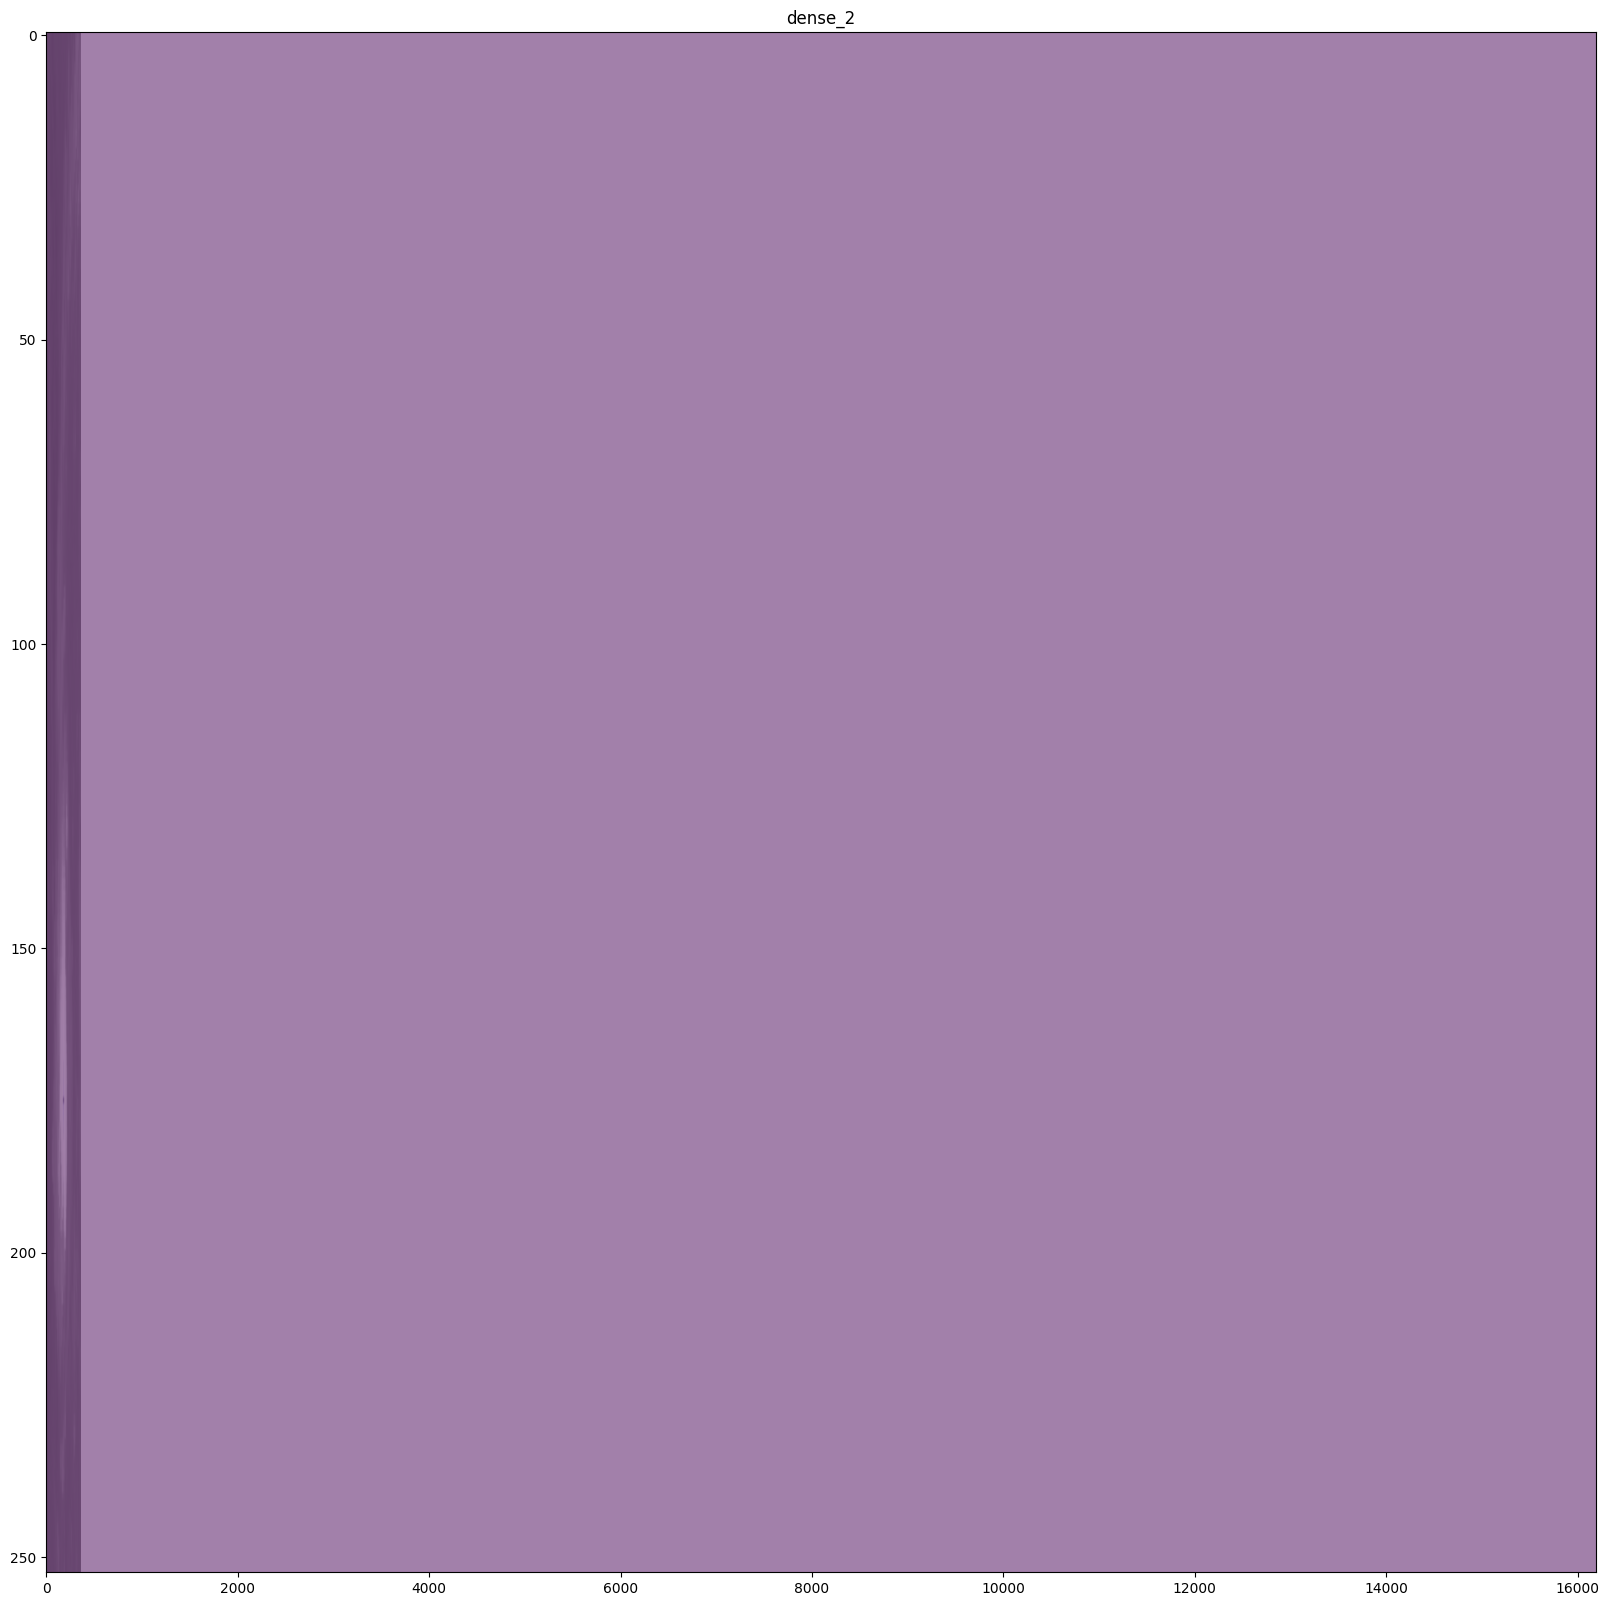

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

# Define a new model that outputs the intermediate layer activations
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

# Prepare the input image
im = cv2.imread('/content/drive/MyDrive/RBL/INSAT 3D Dataset/25.jpg')


input_image = "/content/drive/MyDrive/RBL/INSAT 3D Dataset/25.jpg"
input_image = tf.keras.preprocessing.image.load_img(input_image, target_size=(512, 512))
input_image = tf.keras.preprocessing.image.img_to_array(input_image)
input_image = np.expand_dims(input_image, axis=0)

# Run the image through the new model
successive_feature_maps = visualization_model.predict(input_image)

# Get layer names
layer_names = [layer.name for layer in model.layers[1:]]
print(layer_names)
print(len(layer_names))

# Visualize the feature maps
for layer_name, feature_map in zip(layer_names[-5:], successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Process feature map for visualization
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x

        # Display the feature map
        plt.figure(figsize=(20, 20))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(im, aspect='auto', alpha=0.5)
        plt.imshow(display_grid, aspect='auto', cmap='viridis', alpha=0.5)
        plt.show()
# for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#     if len(feature_map.shape) == 4:
#         # Process feature map
#         n_features = feature_map.shape[-1]
#         size = feature_map.shape[1]
#         display_grid = np.zeros((size, size * n_features))
#         for i in range(n_features):
#             x = feature_map[0, :, :, i]
#             x -= x.mean()
#             x /= x.std()
#             x *= 64
#             x += 128
#             x = np.clip(x, 0, 255).astype('uint8')
#             display_grid[:, i * size: (i + 1) * size] = x

#         # Display the feature map
#         plt.figure(figsize=(20, 20))
#         plt.title(layer_name)
#         plt.grid(False)
#         plt.imshow(im, aspect='auto', alpha=0.5)
#         plt.imshow(display_grid, aspect='auto', cmap='viridis', alpha=0.5)
#         plt.show()